In [ ]:
import torch,torchvision
from torchvision import datasets,models,transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

image_transforms = {
    'train': transforms.Compose([
          transforms.Resize((750,200)),
          # transforms.CenterCrop(size={600,60}),
          transforms.ToTensor(),
          transforms.Normalize([0.485,0.456,0.406],
                               [0.229,0.224,0.225])
    ])
}

num_classes = 2
DATASET_X1 = '/content/drive/MyDrive/Deep Learning/SugarCane_Quality/data/HoCP09-804'
DATASET_X2 = '/content/drive/MyDrive/Deep Learning/SugarCane_Quality/data/HoCP96-540'
DATASET_X3 = '/content/drive/MyDrive/Deep Learning/SugarCane_Quality/data/L01-299'
CATAGORIES = ["damaged","good"]

data = {
    'data1': datasets.ImageFolder(DATASET_X1,transform=image_transforms['train']),
    'data2': datasets.ImageFolder(DATASET_X2,transform=image_transforms['train']),
    'data3': datasets.ImageFolder(DATASET_X3,transform=image_transforms['train'])
}

data1 = DataLoader(data['data1'],batch_size=1,shuffle=True)
data2 = DataLoader(data['data2'],batch_size=1,shuffle=True)
data3 = DataLoader(data['data3'],batch_size=1,shuffle=True)

training_data = []
validation_data = []
testing_data_1 = []
testing_data_2 = []
testing_data_3 = []

def create_data():
  i = 0
  l1 = len(data1)
  for ele in data1:
    if i < (7*l1/11):
      training_data.append(ele)
    elif i < (8*l1/11):
      validation_data.append(ele)
    else:
      testing_data_1.append(ele)
    i+=1
  
  i = 0
  l1 = len(data2)
  for ele in data2:
    if i < (6*l1/10):
      training_data.append(ele)
    elif i < (7*l1/10):
      validation_data.append(ele)
    else:
      testing_data_2.append(ele)
    i+=1

  i = 0
  l1 = len(data3)
  for ele in data3:
    if i < (5*l1/10):
      training_data.append(ele)
    elif i < (7*l1/10):
      validation_data.append(ele)
    else:
      testing_data_3.append(ele)
    i+=1


create_data()

import random

random.shuffle(training_data)

len(training_data),len(validation_data),len(testing_data_1),len(testing_data_2),len(testing_data_3)


(1736, 315, 381, 321, 121)

In [ ]:
alexnet = models.alexnet(pretrained=True)

# Freeze Model Parameters
i = 0
for param in alexnet.parameters():
  i += 1
  param.requires_grad = False
  if i >= 9:
    break

alexnet.classifier[6] = nn.Linear(4096,2)
alexnet.classifier.add_module("7",nn.LogSoftmax(dim=1))

# Define Optimizer and Loss function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())


def train_and_validate(model,loss_criterion,optimizer,epochs=25):
  start = time.time()
  history = []
  best_acc = 0.0

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1,epochs))

    # Set to training mode
    model.train()

    # Loss and accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i,(inputs,labels) in enumerate(training_data):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Clean existing gradients
      optimizer.zero_grad()

      if torch.cuda.is_available():
        model.cuda()

      # Forward pass - compute outputs on input data using the model
      outputs = model(inputs)

      # Compute loss
      loss = loss_criterion(outputs,labels)

      # Backpropagate the error
      loss.backward()

      # Update the parameters
      optimizer.step()

      # Compute the total loss for the batch and add it to train loss
      train_loss += loss.item() * inputs.size(0)

      ret, predictions = torch.max(outputs.data,1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
      model.eval()

      for j,(inputs,labels) in enumerate(validation_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        if torch.cuda.is_available():
          model.cuda()
        outputs = model(inputs)

        loss = loss_criterion(outputs,labels)

        valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data,1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)

      avg_train_loss = train_loss/len(training_data)
      avg_train_acc = train_acc/len(training_data)

      avg_valid_loss = valid_loss/len(validation_data)
      avg_valid_acc = valid_acc/len(validation_data)

      history.append([avg_train_loss,avg_valid_loss,avg_train_acc,avg_valid_acc])

      epoch_end = time.time()

      print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

  return model,history


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 20
trained_model, history = train_and_validate(alexnet,loss_func,optimizer,num_epochs)

torch.save(history,'/content/drive/MyDrive/Deep Learning/SugarCane_Quality/1_history.pt')


Epoch: 1/20
Epoch : 001, Training: Loss: 1.3397, Accuracy: 53.6290%, 
		Validation : Loss : 0.6624, Accuracy: 61.2698%, Time: 80.9273s
Epoch: 2/20
Epoch : 002, Training: Loss: 0.8766, Accuracy: 61.4055%, 
		Validation : Loss : 0.5838, Accuracy: 69.2063%, Time: 81.0528s
Epoch: 3/20
Epoch : 003, Training: Loss: 0.8134, Accuracy: 69.4700%, 
		Validation : Loss : 0.5250, Accuracy: 79.3651%, Time: 81.1751s
Epoch: 4/20
Epoch : 004, Training: Loss: 0.7771, Accuracy: 71.8318%, 
		Validation : Loss : 0.5342, Accuracy: 78.0952%, Time: 81.0796s
Epoch: 5/20
Epoch : 005, Training: Loss: 0.6467, Accuracy: 74.5392%, 
		Validation : Loss : 0.6194, Accuracy: 74.2857%, Time: 81.0354s
Epoch: 6/20
Epoch : 006, Training: Loss: 0.6473, Accuracy: 77.8802%, 
		Validation : Loss : 0.6605, Accuracy: 78.7302%, Time: 81.0038s
Epoch: 7/20
Epoch : 007, Training: Loss: 0.5380, Accuracy: 79.7235%, 
		Validation : Loss : 0.8224, Accuracy: 74.9206%, Time: 81.0699s
Epoch: 8/20
Epoch : 008, Training: Loss: 0.5312, Accura

In [ ]:
PATH = '/content/drive/MyDrive/Deep Learning/SugarCane_Quality' + 'model3.pt'
torch.save(trained_model.state_dict(), PATH)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#  For Testing data 1
correct = 0
total = 0

for i,(inputs,labels) in enumerate(testing_data_1):
  inputs = inputs.to(device)
  labels = labels.to(device)

  if torch.cuda.is_available():
    trained_model.cuda()

  outputs = trained_model(inputs)
  loss = loss_func(outputs,labels)
  out = 0
  if outputs[0][0] > outputs[0][1]:
    out = 0
  else:
    out = 1
  if labels == torch.tensor([0], device='cuda:0'):
    out1 = 0
  else:
    out1 = 1

  if out == out1:
    correct+=1
  
  total += 1

print("Testing data 1: ")
print((correct*100.0)/total)


# For Testing data 2
correct = 0
total = 0

for i,(inputs,labels) in enumerate(testing_data_2):
  inputs = inputs.to(device)
  labels = labels.to(device)

  if torch.cuda.is_available():
    trained_model.cuda()

  outputs = trained_model(inputs)
  loss = loss_func(outputs,labels)
  out = 0
  if outputs[0][0] > outputs[0][1]:
    out = 0
  else:
    out = 1
  if labels == torch.tensor([0], device='cuda:0'):
    out1 = 0
  else:
    out1 = 1

  if out == out1:
    correct+=1
  
  total += 1

print("Testing data 2: ")
print((correct*100.0)/total)

# For Testing data 2
correct = 0
total = 0

y_train = []
y_predicted = []


for i,(inputs,labels) in enumerate(testing_data_3):
  inputs = inputs.to(device)
  labels = labels.to(device)

  if torch.cuda.is_available():
    trained_model.cuda()

  outputs = trained_model(inputs)
  loss = loss_func(outputs,labels)
  out = 0
  if outputs[0][0] > outputs[0][1]:
    out = 0
    y_predicted.append(0)
  else:
    out = 1
    y_predicted.append(1)
  if labels == torch.tensor([0], device='cuda:0'):
    out1 = 0
    y_train.append(0)
  else:
    out1 = 1
    y_train.append(1)

  if out == out1:
    correct+=1
  
  total += 1

print("Testing data 3: ")
print((correct*100.0)/total)


Testing data 1: 
78.47769028871392
Testing data 2: 
77.88161993769471
Testing data 3: 
81.81818181818181


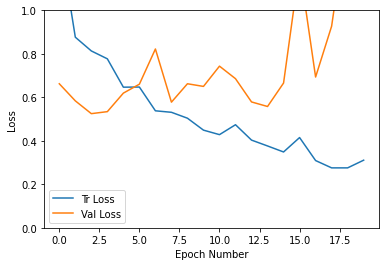

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

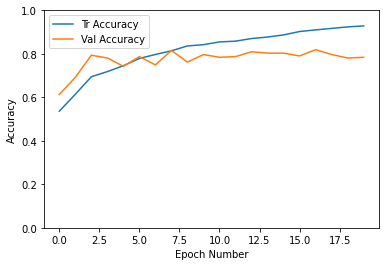

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output we get
good
Actual output
good


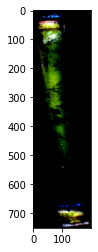

In [ ]:
img = training_data[0][0][0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img)

output = trained_model(training_data[0][0].to(device))
label = training_data[0][1]


if output[0][0] > output[0][1]:
  out = 0
else:
  out = 1
classes = ["damaged","good"]
print("Output we get")
print(classes[out])

if label == torch.tensor([0]):
  out1 = 0
else:
  out1 = 1
print("Actual output")
print(classes[out1])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_train,y_predicted)
print(cf_matrix)

[[63 14]
 [ 8 36]]


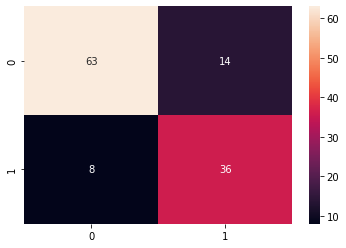

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
